### Preliminary Actions

In [1]:
# There are many warnings regarding the updates in the future releases of the libraries. Ignore them.
import warnings
warnings.filterwarnings("ignore")

# Set the backend of matplotlib to inline
%matplotlib inline

# Import necessary libraries
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Change the plot style
sns.set(style="ticks")

# Read the csv file created in the Data Wrangling section
df=pd.read_csv('wrangled_data.csv')

# Convert RUCC from numerical to string
df.RUCC = df.RUCC.apply(lambda x:str(x))

#Print the first five rows of the data
df.head()

,state,county,region,RUCC,less_than_high_school,high_school_diploma,college/associate_degree,bachelors/higher,unemployment,poverty_log
0,AL,Autauga County,South,2,12.417,34.331,28.660,24.593,5.1,2.639057
1,AL,Baldwin County,South,3,9.972,28.692,31.788,29.547,5.4,2.484907
2,AL,Barbour County,South,6,26.236,34.927,25.969,12.868,8.4,3.401197
3,AL,Bibb County,South,1,19.302,41.816,26.883,12.000,6.5,2.995732
4,AL,Blount County,South,1,19.969,32.942,34.039,13.050,5.4,2.639057


### Numerical Features

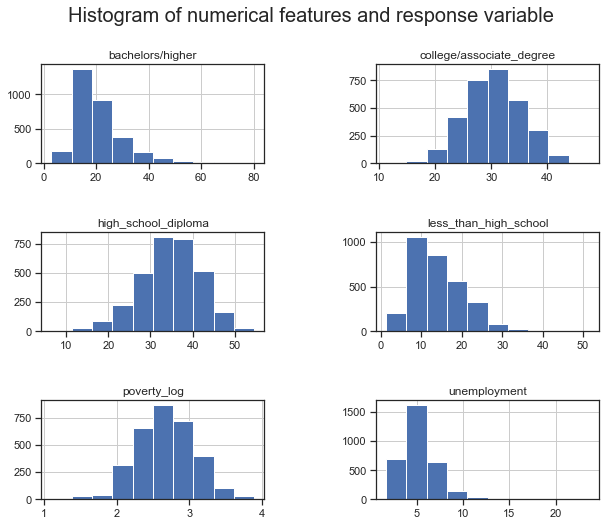

In [2]:
# PLot histogram of numerical features and response variable (poverty_log)
numerical = ['less_than_high_school','high_school_diploma','college/associate_degree','bachelors/higher',
             'poverty_log','unemployment']
df.loc[:,numerical].hist(figsize=(10,8))
plt.subplots_adjust(hspace=0.7,wspace=0.5)
plt.suptitle("Histogram of numerical features and response variable",fontsize=20)
plt.show()

In [3]:
# The sum of the four education levels is 100. Therefore, one of them must be removed before building the predictive model.
# Since 'bachelors/higher' has the highest skewness and requires data transformation, it is removed.
del df['bachelors/higher']

In [3]:
# In order to address outliers, some features should be capped, floored, or both.
def cap_floor(feature,cap=False,floor=False):
    """This function caps and/or floors outliers of the feature parameter. A value is capped if it is more than 99th percentile 
    or the outlier threshold by box plot (which is 75th percentile plus 1.5 interquartile range) whichever is larger.
    A value is floored if it is less than 1th percentile or the outlier threshold by box plot 
    (which is 25th percentile minus 1.5 interquartile range) whichever is smaller. Since all numerical features are in 
    percentage, the value will be capped and floored at 100 and 0, respectively if capping and flooring is not required"""

    # Define different quantiles and IQR
    q1 = df[feature].quantile(0.01)
    q25 = df[feature].quantile(0.25)
    q75 = df[feature].quantile(0.75)
    q99 = df[feature].quantile(0.99)
    iqr = q75-q25     
    lower_limit = min(q1,q25-1.5*iqr) if floor else 0
    upper_limit = max(q99,q75+1.5*iqr) if cap else 100
    df[feature].clip(lower_limit,upper_limit,inplace=True)

In [4]:
# Apply cap floor on the four numerical features
cap_floor('less_than_high_school',cap=True)
cap_floor('high_school_diploma',floor=True)
cap_floor('college/associate_degree',cap=True,floor=True)
cap_floor('unemployment',cap=True)

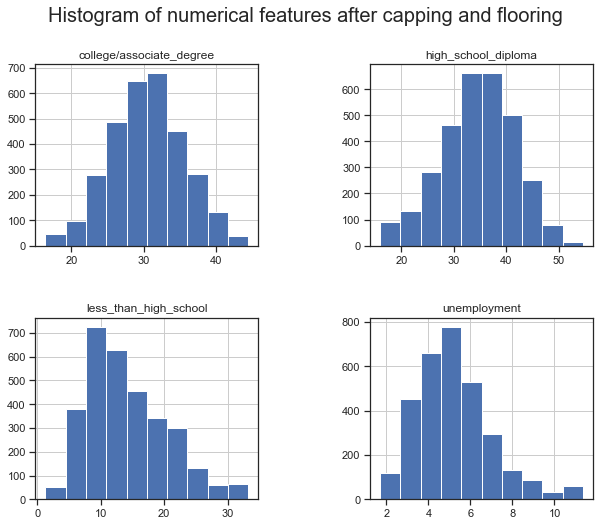

In [5]:
# Re-plot histogram of numerical features
numerical_features = ['less_than_high_school','high_school_diploma','college/associate_degree','unemployment']
df.loc[:,numerical_features].hist(figsize=(10,8))
plt.subplots_adjust(hspace=0.4,wspace=0.5)
plt.suptitle("Histogram of numerical features after capping and flooring",fontsize=20)
plt.show()

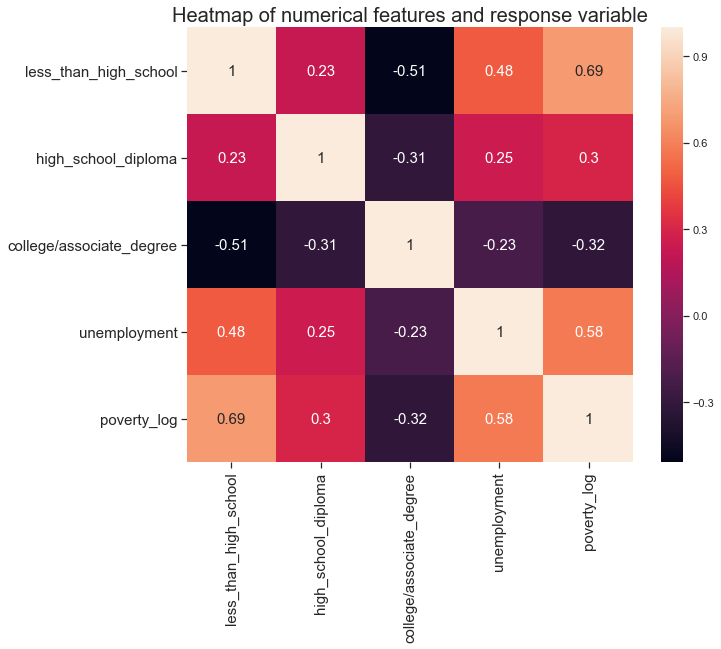

In [6]:
# Create the heatmap of numerical features as well as response variable (poverty)
plt.figure(figsize=(10,8))
corr = df.loc[:,['less_than_high_school','high_school_diploma','college/associate_degree','unemployment','poverty_log']].corr()
sns.heatmap(corr,annot=True,annot_kws={'size':15})
plt.tick_params(axis='both',labelsize = 15)
plt.title('Heatmap of numerical features and response variable',fontsize=20)
plt.show()

In [8]:
# No highly correlated features (more than 0.9 or less than -0.9) are found
# The linear regression model will be built once with the original format of the numerical features and once with their
# logarithmic transformation. The log transformation of the each feature will be stored in a new column.
for feature in numerical_features:
    df[feature+'_log']=np.log(df[feature])

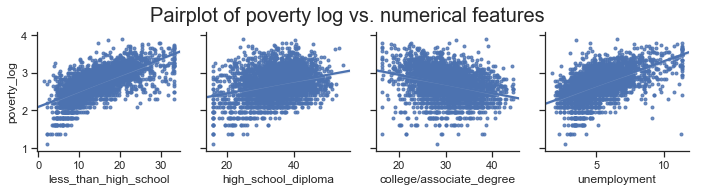

In [9]:
# pairplot poverty log vs numerical features
g=sns.pairplot(df,x_vars=['less_than_high_school','high_school_diploma','college/associate_degree','unemployment']
               ,y_vars=['poverty_log'],kind="reg",markers='.')
g.fig.suptitle("Pairplot of poverty log vs. numerical features",fontsize=20,y=1.05)
plt.show()

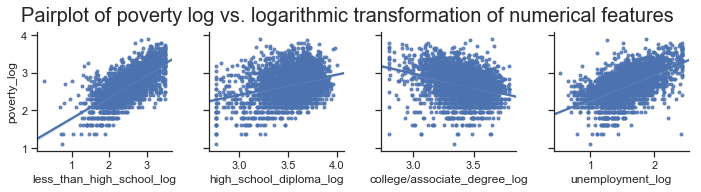

In [10]:
# pairplot poverty log vs log transformation of numerical features
g=sns.pairplot(df,x_vars=['less_than_high_school_log','high_school_diploma_log','college/associate_degree_log',
                          'unemployment_log'],y_vars=['poverty_log'],kind="reg",markers='.')
g.fig.suptitle("Pairplot of poverty log vs. logarithmic transformation of numerical features",fontsize=20,y=1.05)
plt.show()

In [11]:
# The relationship between the logarithmic transformation of ‘less_than_high_school’ and ‘unemployment’, and the response 
# variable slightly look more linear than the relationship between their original format and the response variable. 
# Therefore, the predictive models will be built once with the original format of the numerical features and once with their 
# logarithmic transformation, the results will be compared, and the better one will be selected. 

### Categorical Features

In [12]:
# Define a function which plots the distribution of poverty_log across all levels of a categorical feature

def poverty_distribution(feature,legend_loc):
    """This function creates the box plot distribution of poverty_log across all levels of the feature parameter"""
    
    # Create the boxplot of the poverty for each level of the feature
    figure, ax = plt.subplots(figsize=(10,6))
    sns.boxplot(ax=ax, x=feature, y='poverty_log', data=df)
    ax.set_title('Box plot of poverty_log across all levels of {}'.format(feature),fontsize = 20, y = 1.02)
    ax.set_xlabel(feature,fontsize = 20)
    ax.set_ylabel('poverty_log',fontsize = 20)
    ax.tick_params(axis='both', labelsize=20)
    #ax.set_ylim(0,50)
    plt.show()

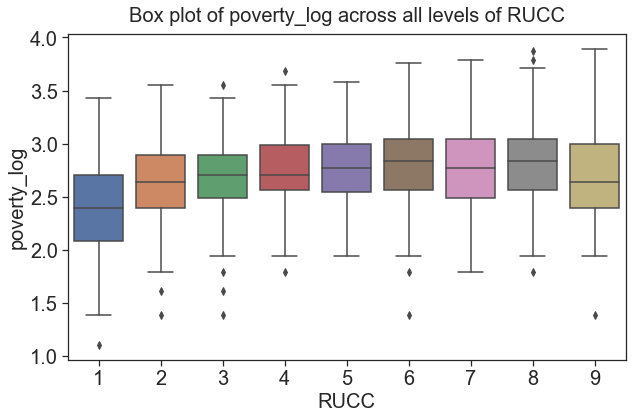

In [13]:
# Apply poverty_distribution on RUCC
poverty_distribution('RUCC',(1,0.32))

In [14]:
# Poverty_log distribution across the nine RUCC is showing the poverty log is lowest for RUCC 1, and highest across RUCC 4-9. 
# Therefore, a new feature could be define with three levels; RUCC 1, RUCC 2-3, and RUCC 4-9.
def rucc_red(rucc):
    """This function assigns a string value to each RUCC to reduce the number of RUCC levels"""
    if rucc == '1':
        return '1'
    elif rucc in ['2','3']:
        return '2-3'
    else:
        return '4-9'

In [15]:
# Create the new column RUCC_reduced
df['RUCC_reduced']=df.loc[:,'RUCC'].apply(lambda x: rucc_red(x))

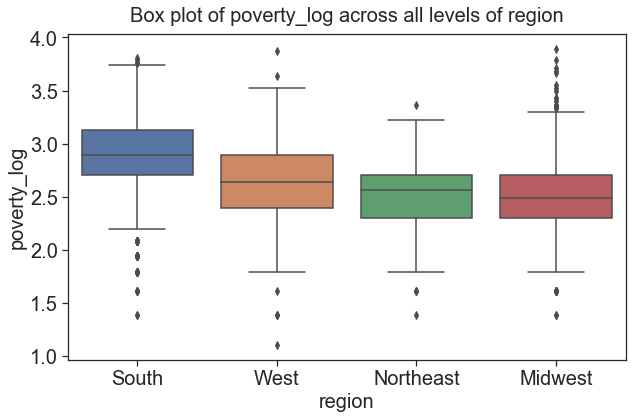

In [16]:
# Apply poverty_distribution on region
poverty_distribution('region',(1,0.65))

In [17]:
# Northeast and Midwest could be merged into one level
df['region_reduced'] = df['region'].apply(lambda x:'Northeast_Midwest' if x in ['Northeast','Midwest'] else x)

In [ ]:
# The predictive models will be built once with the original categorical features and once with the reduced format, 
# the results will be compared, and the better one will be selected.

In [18]:
# Save the dataframe into a csv file
df.to_csv('data_updated.csv',index=False)